[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  4 of 4 completed
NaN in data! Fixed.
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.28348061 0.93958657]
 ...
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.16723317 0.75616054]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.1652852 , 0.1652852 , 0.16466383, ..., 0.10357205, 0.11526856,
        0.11526856],
       [0.1652852 , 0.16466383, 0.16466383, ..., 0.11526856, 0.11526856,
        0.10968367],
       [0.16466383, 0.16466383, 0.1669017 , ..., 0.11526856, 0.10968367,
        0.10968367],
       ...,
       [0.73869606, 0.73267182, 0.73267182, ..., 0.75404546, 0.75404546,
        0.77007934],
       [0.73267182, 0.73267182, 0.72554083, ..., 0.75404546, 0.77007934,
        0.77007934],
       [0.73267182, 0.72554083, 0.72554083, ..., 0.77007934, 0.77007934,
        0.76770556]])

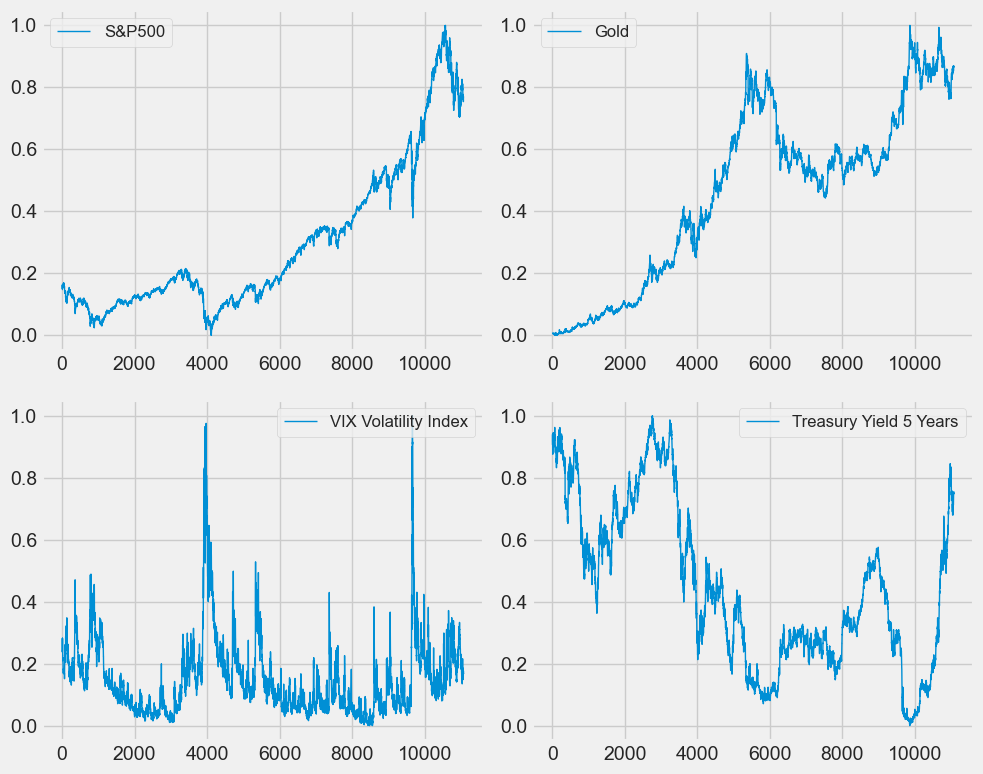

In [10]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass_module as dataclass_module
reload(dataclass_module)

input_length = 30
output_length = 100
output_steps_ahead = 1
database = dataclass_module.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [11]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

'''
class Stockdataset(Dataset):
    def __init__(self, data, input_length, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
'''
     
size_training = int(len(database.data_norm)*0.95)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = dataclass_module.Stockdataset(data_train, input_length, output_length)
test_dataset = dataclass_module.Stockdataset(data_test, input_length, output_length)
whole_dataset = dataclass_module.Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)

training_batch_size = 213; #513
batch_size = training_batch_size
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, batch_size, drop_last = True, shuffle=False)
#whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


(10519, 4)
(554, 4)
torch.Size([30, 4])
torch.Size([100])
torch.Size([30, 4])
cuda


In [12]:
import utils.loss_module as loss_module
reload(loss_module)

loss_fun_con = nn.MSELoss()
loss_fun_centers = nn.MSELoss()
loss_fun_recon = nn.MSELoss()
loss_fun_assign = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="sum", log_target=True) #vhodi morajo bit logaritmirani
loss_fun_balance = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction="sum", log_target=True) #vhodi morajo bit logaritmirani
loss_fun_Kmeans = loss_module.KMeansClusteringLoss()
loss_fun_local = loss_module.LocalityPreservingLoss()
loss_fun_DQA = loss_module.QuadraticDiscriminantAnalysis()
loss_fun_GMM = loss_module.GaussianMixtureLoss()
loss_fun_FCM = loss_module.FuzzyCMeansClusteringLoss()
loss_fun_overlap = loss_module.OverlappingLoss()
loss_fun_ContrastiveLoss = loss_module.FuzzyContrastiveLoss(0.2)
loss_fun_FuzzyCMeansLossWithPenalties = loss_module.FuzzyCMeansLossWithPenalties()
loss_fun_TotalVariationLoss = loss_module.TotalVariationLoss()
loss_fun_orthogonality_penalty = loss_module.OrthogonalityLoss()
loss_fun_EntropyLoss = loss_module.EntropyLoss(1)
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture


In [13]:
from utils import display_module
reload(display_module)
from utils import checks_module
reload(checks_module)

import models.evolving_system_module as evolving_system_module
reload(evolving_system_module)
import models.feed_forward_module as feed_forward_module
reload(feed_forward_module)



<module 'models.feed_forward_module' from 'C:\\Users\\Miha\\OneDrive - Univerza v Ljubljani\\Doktorski_studij\\Delo\\Evolving transformer\\models\\feed_forward_module.py'>

In [14]:
class MultiheadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, sequence_length):
        super(MultiheadSelfAttention, self).__init__()
        self.msa = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.glu  = torch.nn.GLU()
        self.ff_ant = feed_forward_module.FeedForward(embed_dim, embed_dim, embed_dim)

        self.embed_dim = embed_dim
        
        self.fc_query = nn.Linear(embed_dim, embed_dim)
        self.fc_key = nn.Linear(embed_dim, embed_dim)

        # Batch normalization layers
        self.bn = nn.BatchNorm1d(sequence_length,track_running_stats = False)
        self.ln = nn.LayerNorm(embed_dim)
        
        # Non-linearities
        self.SiLU = nn.SiLU()

    def forward(self, x, x_embed, attn_mask=None):
        query = self.SiLU(self.fc_query(x_embed))
        key = self.SiLU(self.fc_key(x_embed))

        x_att, weights = self.msa(query, key, key, attn_mask=attn_mask, need_weights=True,average_attn_weights=False)
        x_residual = self.ln(self.ff_ant(x_att) + x_embed)

        return x_residual, weights

class StackedAttentionNetwork(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers,seq_length):
        super(StackedAttentionNetwork, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.att_layers = nn.ModuleList([
            MultiheadSelfAttention(self.embed_dim, self.num_heads, self.seq_length)
            for _ in range(self.num_layers)
        ])
        self.flat = nn.Linear(self.embed_dim, 1)

    def create_attention_mask(self, seq_length):
        # Create a 2D square matrix with seq_length dimensions.
        mask = torch.triu(torch.ones((seq_length, seq_length)), diagonal=1)
    
        # Convert all values of 1 to -float('Inf') to prevent attending to future sequence elements.
        mask[mask == 1] = -float('Inf')

        return mask

    def forward(self, x, x_embed):
        batch_size, seq_length, input_dim = x.size()
        x = x_embed
        all_att_weights = torch.empty((self.num_layers, self.num_heads, seq_length, seq_length))

        # Create attention mask and move it to the same device as x
        attn_mask = self.create_attention_mask(seq_length).to(x.device)

        for layer_idx in range(self.num_layers):
            att_layer = self.att_layers[layer_idx]
            x, att_weights = att_layer(x, x, attn_mask=attn_mask)  # Pass the mask to the attention layer
            all_att_weights[layer_idx] = att_weights.mean(dim=0)

        
        x_flat = self.flat(x).transpose(2, 1)
        return x_flat, all_att_weights

In [15]:
from importlib import reload 
import utils.ellipse_module as ellipse_module
reload(ellipse_module)


<module 'utils.ellipse_module' from 'C:\\Users\\Miha\\OneDrive - Univerza v Ljubljani\\Doktorski_studij\\Delo\\Evolving transformer\\utils\\ellipse_module.py'>

In [16]:
import math

class PositionalEmbedding(nn.Module):
    def __init__(self, input_length, input_channels, embed_dimension):
        super(PositionalEmbedding, self).__init__()
        self.embedding = nn.Linear(input_channels, embed_dimension)
        self.positional_embedding = nn.Embedding(input_length, embed_dimension)

    def forward(self, x):
        sequence_length = x.size(1)
        positions = torch.arange(0, sequence_length, device=x.device).unsqueeze(0)
        positions = positions.expand(x.size(0), -1)
        pos_embedding = self.positional_embedding(positions)
        x = self.embedding(x) + pos_embedding
        return x

class CosinePositionalEncoding(nn.Module):
    def __init__(self, input_sequence_length, input_channels, embed_dimension):
        super(CosinePositionalEncoding, self).__init__()
        self.embedding = nn.Linear(input_channels, embed_dimension)
        self.embed_dimension = embed_dimension

    def forward(self, x):
        batch_size, seq_length, input_channels = x.size()
        positions = torch.arange(seq_length, device=x.device).float().unsqueeze(0)
        div_term = torch.exp(torch.arange(0, self.embed_dimension, 2, device=x.device).float() * (-math.log(10000.0) / self.embed_dimension))
        pos_embedding = torch.zeros(batch_size, seq_length, self.embed_dimension, device=x.device)
        pos_embedding[:, :, 0::2] = torch.sin(positions.unsqueeze(-1) * div_term)
        pos_embedding[:, :, 1::2] = torch.cos(positions.unsqueeze(-1) * div_term)
        x = self.embedding(x)
        x_embed = x + pos_embedding
        return x, x_embed


In [17]:

    
class Evolver(nn.Module):
    def __init__(self,batch_size, par_input_channels, par_input_length, par_output_dim, par_output_length, par_hidden_size, par_num_layers,
                  par_num_heads,par_embed_dim, par_num_clusters, par_regressor_dim, par_exogenous_dim, par_order, par_latent_dim,min_clump,max_clamp):
        super(Evolver, self).__init__()
        self.num_layers = par_num_layers
        self.input_channels = par_input_channels
        self.input_length = par_input_length
        self.output_dim = par_output_dim
        self.output_length = par_output_length
        self.hidden_size = par_hidden_size
        self.num_clusters = par_num_clusters
        self.num_heads = par_num_heads
        self.embed_dim = par_embed_dim
        self.regressor_dim = par_regressor_dim
        self.exogenous_dim = par_exogenous_dim
        self.order = par_order
        self.latent_dim = par_latent_dim
        self.min_clump = min_clump
        self.max_clamp = max_clamp
        self.batch_size = batch_size
        #self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=hidden_size, num_layers=num_layers)
        #self.fc = nn.Linear(input_dim, output_dim)
        #self.MSA = MultiheadSelfAttention(input_length, cluster_dim, num_clusters, embed_dim, num_heads, num_layers)
        self.embed =  CosinePositionalEncoding(self.input_length, self.input_channels, self.embed_dim)
        self.MSAs_ant = StackedAttentionNetwork(self.embed_dim, self.num_heads, self.num_layers, self.input_length)
        self.MSAs_con = StackedAttentionNetwork(self.embed_dim, self.num_heads, self.num_layers, self.input_length)
        #self.VAE = VariationalAutoencoder(input_length, cluster_dim, num_clusters)
        #self.fc = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters, hidden_size)
        self.fc_ant = feed_forward_module.FeedForward(self.input_length, self.latent_dim, self.input_length) #self.cluster_dim
        self.fc_member = feed_forward_module.FeedForward(self.input_length, self.num_clusters, self.input_length) #self.cluster_dim
        self.fc_con = feed_forward_module.FeedForward(self.input_length, self.exogenous_dim, self.input_length) #self.cluster_dim
        self.evolve = evolving_system_module.EvolvingSystem(self.batch_size, self.input_length, self.output_dim, self.output_length, self.num_clusters, self.latent_dim, self.regressor_dim, 
                                                            self.exogenous_dim, self.order, self.min_clump, self.max_clamp)
        self.softmax_member = torch.nn.Softmax(dim = 2)
        self.sm = torch.nn.Softmax(dim = 2)

    def forward(self, x):
        #self.en, (hn, cn) = self.lstm(x, (hn, cn))
        #self.en = self.fc(self.en).reshape(batch_size, 1,input_length)
        #self.att = self.MSA(self.en)   
        #x = self.fc(x).reshape(batch_size, 1,input_length)
        
        #self.att, self.att_weights = self.MSA(x)
        self.x = x[:,:,0]
        x, x_embed = self.embed(x)
        self.att_ant, self.att_weights = self.MSAs_ant(x, x_embed)
        self.att_con, self.att_weights_con = self.MSAs_con(x, x_embed)
        #self.flat(self.ant_layer_norm(self.ff_ant(x_att) + x_att)).transpose(2, 1)  
        self.z = self.fc_ant(self.sm(self.att_ant))
        self.u = self.fc_con(self.att_con)
        self.member = self.softmax_member(self.fc_member(self.att_ant))
        #self.u = torch.cat((x[:, -1, 0].reshape(-1, 1, 1), self.z),dim=2)
        #device = z.device  # Get the device of the input tensor
        #self.u = torch.cat((self.u, torch.ones((self.batch_size, 1, 1)).to(device)), dim=2)  # Move self.ones to the same device as input
        #self.u = torch.cat((x[:,-1,0].reshape(-1,1,1),self.fc_con(self.att), torch.ones([batch_size, 1, 1])), dim = 2)
        self.y, x_recon = self.evolve( (self.x[:,-self.order:]), self.z, self.u.squeeze(1), self.member)
        #final_out = self.fc(out)
        
        return self.y, x_recon
    
    #def init(self):
    #    h0 = torch.zeros(batch_size, self.num_layers, self.hidden_size).to(device) #zakaj je batch_size tako?
    #    c0 = torch.zeros(batch_size, self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je treba to dodat tle?
    #    return h0, c0


In [18]:


par_num_heads = 20
par_num_clusters = 30
par_input_channels = 4
par_embed_dim = 40 #Must be devisible by 2 due to embedding and by the par_num_heads
par_output_dim = 1
par_hidden_size = 100
par_num_layers = 1
par_order = input_length
par_exogenous_dim = output_length
par_regressor_dim = par_order+1 +1
par_latent_dim = 3
par_input_length = input_length
par_output_length = output_length
par_min_clump = 0
par_max_clump = 10
model = Evolver(batch_size, par_input_channels, par_input_length, par_output_dim, par_output_length, par_hidden_size, par_num_layers,
                  par_num_heads,par_embed_dim, par_num_clusters, par_regressor_dim, par_exogenous_dim, par_order, par_latent_dim, par_min_clump,par_max_clump).to(device)


TypeError: EvolvingSystem.__init__() takes 11 positional arguments but 12 were given

In [ ]:
import matplotlib.pyplot as plt

def plot_llm(llm_data):
    # Convert the data to a NumPy array
    llm_np = llm_data.detach().cpu().numpy()

    # Plot the data
    plt.plot(llm_np)
    plt.xlabel('Time')
    plt.ylabel('LLM')
    plt.title('LLM over Time')
    plt.show()

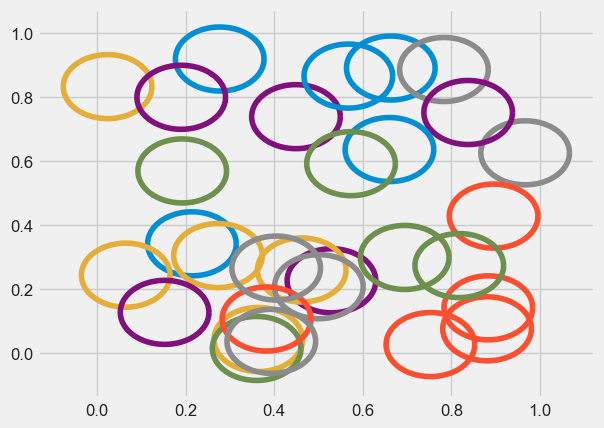

In [ ]:
from IPython import display
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pylab as pl

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul((sigma_inv), torch.transpose((sigma_inv), 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = ellipse_module.Ellipse(sigma,mu,1)
ellipse_points = ellipse.compute_confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)


def compute_distibution(d2):
    q_num = (1 + d2).pow_(-1)
    q_den = (1 + d2).pow_(-1).sum(2).reshape(-1,1,1)
    q = torch.div(q_num, q_den)
    p_num = torch.div(torch.pow(q, 2), torch.sum(q, 0))
    p_den = torch.sum(torch.div(torch.pow(q, 2), torch.sum(q, 0)),-1).reshape(-1,1,1)
    p = torch.div(p_num, p_den)
    return p

In [ ]:

def train(dataloader, loss_name, epoch):
    
    model.train()
    #alpha = 0.5
    loss_sum = 0
    x_ant = np.empty((0,1,par_latent_dim))    
    
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
  
        if torch.isnan(x).any() == True:           
            print("ERROR training input data!")
        if torch.isnan(y).any() == True:           
            print("ERROR training output data!!")

        out, x_recon = model(x)
        
        if torch.isnan(out).any() == True:           
            print("ERROR Output!")
        if torch.isnan(x_recon).any() == True:           
            print("ERROR Decoder!")

        mu_target = torch.einsum('ij->ji',model.evolve.compute_centers(model.z))
        #sigma_target = model.evolve.compute_sigma(model.z).reshape(num_clusters,cluster_dim,cluster_dim)
        
        loss = torch.zeros(1).to(device)
        loss_kmeans = loss_fun_Kmeans(model.z, model.evolve.mu.detach())
        if torch.isnan(loss_kmeans) == True:           
            print("ERROR loss!")
        loss_FCM = loss_fun_FCM(model.z, model.evolve.mu, model.evolve.sigma_inv)

        #loss_GMM = loss_fun_GMM(model.z, model.evolve.mu, model.evolve.sigma_inv)       
        loss_con = loss_fun_con(out.reshape(batch_size, par_output_dim,-1), y.reshape(batch_size, par_output_dim,-1))
        
        if loss_name == 'all':

            total_loss, loss_FCM_, loss_KM, equal_spread_loss, pull_towards_clusters_loss, column_norm_loss = loss_fun_FuzzyCMeansLossWithPenalties(model.z, model.evolve.mu, model.evolve.sigma_inv,1,1)
            loss_mu = loss_fun_centers(mu_target, model.evolve.mu)
            #loss_sigma = loss_fun_sigma(sigma_target, model.evolve.mu)
            #loss_DQA = loss_fun_DQA(model.z, model.evolve.mu, model.evolve.sigma_inv)
            loss_GMM = loss_fun_GMM(model.z, model.evolve.mu, model.evolve.sigma_inv)
            #loss_assign = loss_fun_assign(torch.nn.functional.log_softmax(model.evolve.psi, -1), compute_distibution(model.evolve.d2.reshape(-1,1,num_clusters)))
            loss_recon = loss_fun_recon(x_recon, x[:,:,0].reshape(batch_size, 1, input_length))
            #loss_ballance = loss_fun_balance(model.evolve.compute_psi(model.z.detach())/batch_size,
            #                                torch.nn.functional.log_softmax(1/par_num_clusters*torch.ones(1,par_num_clusters),dim=1).to(device))
            loss_ballance = loss_fun_balance(model.evolve.compute_psi(model.z.detach())/batch_size,
                                            1/par_num_clusters*torch.ones(1,par_num_clusters).to(device))
            #loss_psi = -torch.sum(1/torch.log(model.evolve.compute_psi(model.z)))/batch_size
            #loss_psi = -torch.sum(torch.log(model.evolve.compute_psi(model.z))/batch_size)
            loss_overlap = loss_fun_overlap(model.evolve.mu, model.evolve.sigma_inv.detach())
            loss_ContrastiveLoss =  loss_fun_ContrastiveLoss(model.z, model.evolve.mu.detach(), model.evolve.sigma_inv.detach())
            TotalVariationLoss = loss_fun_TotalVariationLoss(model.evolve.x_LLM, model.evolve.y_LLM)
            orthogonality_penalty =  loss_fun_orthogonality_penalty(model.evolve.x_LLM)
            BalanceMaxActivationsLoss = loss_fun_BalanceMaxActivationsLoss(model.evolve.compute_psi(model.z))
            EntropyLoss = loss_fun_EntropyLoss(model.evolve.mu, model.evolve.sigma_inv, model.z)
            #SmoothRangeLossX = loss_fun_SmoothRangeLoss(model.evolve.x_LLM)
            #SmoothRangeLossY = loss_fun_SmoothRangeLoss(model.evolve.y_LLM)
            #loss = loss + loss_recon  + loss_centers
            #loss = loss + loss_recon*1e4  + loss_con*1e4 + loss_kmeans*1e2 + loss_ballance# loss + loss_recon  + loss_con + loss_FCM + loss_ContrastiveLoss#
            #+loss_ContrastiveLoss
            loss = loss + loss_con + loss_FCM + loss_ballance + EntropyLoss
    
            #if torch.all(TotalVariatioanLoss > 5):
            #    loss = loss + TotalVariationLoss*1e-2
        '''
        if loss_name == 'encoder':
        
            loss_centers = loss_fun_centers(mu,model.evolve.mu)
            #loss_GMM = loss_fun_GMM(model.z, model.evolve.mu, model.evolve.sigma_inv)
            #loss_assign = loss_fun_assign(torch.nn.functional.log_softmax(model.evolve.psi, -1), compute_distibution(model.evolve.d2.reshape(-1,1,num_clusters)))
            loss_recon = loss_fun_recon(x_recon, x[:,:,0].reshape(batch_size, 1, input_length))
            loss_ballance = loss_fun_balance(torch.nn.functional.log_softmax(1/num_clusters*torch.ones(1,num_clusters).to(device),dim=1), torch.sum(model.evolve.compute_psi(model.z),0)/batch_size)

            #loss = loss + loss_recon  + loss_centers
            loss = loss + loss_recon#  + loss_centers               

          
        if loss_name == "cluster":

            loss_FCM = loss_fun_FCM(model.z, model.evolve.mu, model.evolve.sigma_inv)

            #loss_ballance = loss_fun_balance(1/num_clusters*torch.ones(1,num_clusters).to(device), torch.log(torch.sum(model.evolve.psi,0)/batch_size))

            loss_GMM = loss_fun_GMM(model.z, model.evolve.mu, model.evolve.sigma_inv)
            loss_centers = loss_fun_centers(mu,model.evolve.mu)
            #loss = loss + loss_FCM + loss_centers
            loss = loss + loss_centers  + loss_kmeans   
            #breakpoint()
            if torch.isnan(loss) == True:           
                print(f"ERROR loss_clust {loss_clust}!")
                breakpoint()
'''

        if loss_name == 'output':
            loss = loss + loss_con
            
        loss_sum = loss_sum + loss.item()  
        if torch.isnan(loss) == True:           
            print("ERROR loss!")

        x_ant = np.append(x_ant, model.z.detach().cpu().numpy(),axis=0)
        #hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        #cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        if torch.isnan(loss) == True:           
            print("ERROR loss!")
        optimizer.step()

        if torch.any(torch.isnan(model.evolve.mu)) == True:  
            print("ERROR mu!")

        checks_module.check_gradient_health(model)
        
        if (batch == np.floor(len(dataloader)/2)):  #(batch == len(dataloader) -1):    
            #if loss_name == "output" and True:  
                #display.display(pl.gcf())  
            display.clear_output(wait=True)
            plt.plot(model.x[0,:].detach().cpu().numpy().reshape(input_length, 1))
            plt.plot(x_recon[0,:,:].detach().cpu().numpy().reshape(input_length, 1))
            plt.plot(x[0,:,0].detach().cpu().numpy().reshape(input_length, 1))  
            #plt.plot(torch.sum(model.att_weights[0,:,:],dim = 0).detach().cpu().numpy().reshape(input_length, 1))             
            #display_module.plot_llm(model.evolve.x_LLM)
            display_module.visualize_llm_square(model.evolve.y_LLM, epoch)
            plt.show() 
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum, x_ant


'''
model.evolve.mu.grad
model.evolve.sigma_inv.grad
model.evolve.msa.in_proj_weight.grad
model.evolve.msa.in_proj_bias.grad
model.evolve.msa.out_proj.weight.grad
model.evolve.msa.out_proj.bias.grad
model.evolve.fc_ant.weight.grad
model.evolve.fc_ant.bias.grad
model.evolve.fc_con.weight.grad
model.evolve.fc_con.bias.grad
model.evolve.fc_emb.weight.grad
model.evolve.fc_emb.bias.grad
model.evolve.input_layer_norm.weight.grad
model.evolve.input_layer_norm.bias.grad
model.evolve.ant_norm.weight.grad
model.evolve.ant_norm.bias.grad
'''

In [ ]:
import matplotlib.pyplot as plt

def test(dataloader,epoch):
    loss_sum = 0

    # Turn off gradients for testing, saves memory and computations
    with torch.no_grad():
        for batch, item in enumerate(dataloader):
            x, y = item
            x = x.to(device)
            y = y.to(device)
            out, x_recon = model(x)
            loss = loss_fun_con(out.reshape(batch_size, par_output_dim, -1), y.reshape(batch_size, par_output_dim, -1))
            loss_sum = loss_sum + loss.item()

            # Display clustering and membership
            display_module.display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
            display_module.display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy(),epoch)

            # Extract the first channel from x and reshape the tensors
            x = x[:, :, 0].cpu().numpy()
            x_recon = x_recon[:, 0, :].cpu().numpy()
            y = y.cpu().numpy()
            out = out[:, 0, :].cpu().numpy()

            # Create time indices for the data
            time_indices_x = range(x.shape[1])
            time_indices_y = range(x.shape[1], x.shape[1] + y.shape[1])

            # Plot x (0th channel) and x_recon
            plt.figure(figsize=(10, 5))
            plt.plot(time_indices_x, x[0], label='x (0th channel)')
            #plt.plot(time_indices_x, x_recon[0], label='x_recon')

            # Plot y and out
            plt.plot(time_indices_y, y[0], label='y')
            plt.plot(time_indices_y, out[0], label='y hat')

            plt.legend()
            plt.title('Time Series Data')
            plt.show()

        print(f"Test loss: {loss_sum:>7f}")

    return loss_sum

loss_test = test(test_dataloader,0)


RuntimeError: The size of tensor a (3) must match the size of tensor b (30) at non-singleton dimension 2

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
%matplotlib inline
best_model = float('inf')
#plt.ioff()
train_iterations = 10000
batch_size = training_batch_size
for i in range(train_iterations):

    for p in model.parameters():
        p.requires_grad = True 

    loss_name = "all"
    lr = 1e-2
    epochs = 10000
    model.evolve.min_clump = 0.1
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
        
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_encoder, _ = train(train_dataloader,loss_name,epoch)
        if True | (np.mod(epoch,1) == 0): 
            #display_module.display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
            #display_module.display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy())
            #display_module.display_attention(model.att_weights[0,:,:].detach().cpu().numpy())
            
            #plt.plot(torch.mean(model.att_weights[0,:,:],0).detach().cpu().numpy())
            loss_test = test(test_dataloader,epoch)
            if (best_model > loss_test):
                best_model = loss_test
                torch.save(model, "model_evolve_cluster.pt")
                print(f"Save model loss: {loss_test} - ")
            display_module.visualize_attention_weights(model.att_weights.detach().cpu(),epoch)
            plt.show() 
            
    for p in model.parameters():
        p.requires_grad = True 

    for name, param  in model.named_parameters():
        if "evolve.mu" == name:
            param.requires_grad = False
        if "evolve.sigma_inv" == name:
            param.requires_grad = False
    
    loss_name = "encoder"
    lr = 1e-3
    epochs = 0
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_encoder, _ = train(train_dataloader,loss_name)
        
        display_module.display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy(),epoch)
        #mu = model.evolve.compute_centers(model.z).detach().cpu().numpy()
        #plt.plot(mu[0,:], mu[1,:], 'or')
        #
        display_module.display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy())
        #display_module.display_attention(model.att_weights[0,:,:].detach().cpu().numpy())

    for p in model.parameters():
        p.requires_grad = False 
    for name, param  in model.named_parameters():
        if "evolve.mu" == name:
            param.requires_grad = True
        if "evolve.sigma_inv" == name:
            param.requires_grad = True
    
    '''
    with torch.no_grad():
        gmm = BayesianGaussianMixture(n_components=num_clusters, covariance_type='full', init_params="k-means++").fit(x_ant_train.reshape(-1,cluster_dim))
        #mu = Gaus'sianMixture(x_ant_train, model.evolve.mu, model.evolve.sigma_inv)
        u, s, v  = torch.linalg.svd(torch.from_numpy(gmm.covariances_), full_matrices=True)
        s_sqrt = torch.diag_embed(torch.sqrt(s))
        sigma_inv = torch.linalg.inv(torch.matmul(s_sqrt, v))
        mu = torch.from_numpy(gmm.means_)
        for name, param in model.named_parameters():
            if 'evolve.mu' == name:
                param.copy_(mu)
            if 'evolve.sigma_inv' == name:
                param.copy_(sigma_inv) 
       
    #GMM_clusters = GaussianMixture(num_clusters, sparsity=20)
    epochs = 0
    loss_name = "cluster"
    lr = 1e-5
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
           
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_cluster, z_ant_train = train(train_dataloader,loss_name)
                    
        display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())
        mu = model.evolve.compute_centers(model.z).detach().cpu().numpy()
        plt.plot(mu[0,:], mu[1,:], 'or')
        display_membership(model.evolve.compute_psi(model.z).detach().cpu().numpy(), model.z.detach().cpu().numpy())
        #plt.show()
    '''   
    '''     
    for p in model.parameters():
        p.requires_grad = True 
        
    loss_name = "output"    
    
    lr = 1e-3
    epochs = 0
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)    
    for epoch in range(epochs): 
        print(f"Epoch {epoch} - " + loss_name)
        loss_train_output, _ = train(train_dataloader,loss_name)
    '''    

    #display_clustering(model.evolve.sigma_inv, model.evolve.mu, z_ant_train)
    #plt.show()    


In [ ]:
loss_test = test(test_dataloader)
if (best_model > loss_train_encoder):
    best_model = loss_train_encoder
    torch.save(model, "model_evolve_cluster_05_18.pt")

In [ ]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        #hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0]
            y = np.repeat(y.detach().cpu().numpy(),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0]
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [ ]:
from torchsummary import summary

#print(model.evolve.fc_con.bias)
#print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])
model = torch.load("model_evolve_cluster.pt")

#model.load_state_dict(torch.load("model_evolve_cluster.pt"))

model.eval()


In [ ]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [ ]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    x_ant = np.empty((0,1,cluster_dim))
    model.eval()
    with torch.no_grad():
        (hn, cn) = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            #pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)#[0]
            #pred = model.predict(x.reshape(input_length, batch_size, input_dim))[0]
            pred, x_pred, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
            pred = pred.detach().cpu().numpy().reshape(1,-1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy()
            #plt.plot(np.linspace(1,input_length, input_length), x[0,:,0].detach().cpu().numpy())
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),y[0,:].reshape(-1))
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),pred[0,:].reshape(-1))
            #plt.show()
            pred_arr = pred_arr + list(pred.reshape(-1))
            y_arr = y_arr + list(y.reshape(-1))
            x_ant = np.append(x_ant, model.z.detach().cpu().numpy(),axis=0)
            
    return pred_arr, y_arr, x_ant
    
whole_pred_arr, whole_y_arr, x_ant  = simulate(whole_dataloader)



In [ ]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (15, 10))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("model_evolve_cluster.pdf")


In [ ]:
from importlib import reload 
from numpy.linalg import inv
'''
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(torch.log(sigma_inv), torch.transpose(torch.log(sigma_inv), 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())
nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = torch.log(model.evolve.mu).detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()
'''   
'''
sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())

nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]

ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.k')
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.m')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()  
'''
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.m')
display.display_clustering(model.evolve.sigma_inv, model.evolve.mu, model.z.detach().cpu().numpy())   



In [ ]:
history -g


In [ ]:
'''
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
'''